In [1]:
%load_ext ipycache
%load_ext autoreload
%autoreload 2

from pyinstrument import Profiler

/opt/conda/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


# Initialization
## Hyperparameters for discovery

In [2]:
import sys
sys.path.insert(0, '../../../')
from src.discoverers.adsorption.values import calc_co2rr_activities


adsorbate = 'CO'
initial_training_size = 1000
batch_size = 200
quantile_cutoff = 0.95

## Gather validation data

In [3]:
import random
import ase.db


db_dir = '../../pull_data/%s_truncated/' % adsorbate
db = ase.db.connect(db_dir + '%s.db' % adsorbate)
rows = list(db.select())
random.Random(42).shuffle(rows)


def parse_rows(rows):
    features = []
    labels = []
    surfaces = []

    for row in rows:
        features.append(row.id)
        data = row.data
        labels.append(data['adsorption_energy'])
        surface = (data['mpid'], data['miller'], data['shift'], data['top'])
        surfaces.append(surface)

    return features, labels, surfaces


training_features, training_labels, training_surfaces = parse_rows(rows[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_rows(rows[initial_training_size:])

# Hallucinate
## Initialize

In [4]:
from src.discoverers.adsorption.mms import MultiscaleDiscoverer
from src.discoverers.adsorption.models import PrimeModel


# Initialize
model = PrimeModel(db_dir)
discoverer = MultiscaleDiscoverer(model=model,
                                  quantile_cutoff=quantile_cutoff,
                                  value_calculator=calc_co2rr_activities,
                                  batch_size=batch_size,
                                  training_features=training_features,
                                  training_labels=training_labels,
                                  training_surfaces=training_surfaces,
                                  sampling_features=sampling_features,
                                  sampling_labels=sampling_labels,
                                  sampling_surfaces=sampling_surfaces,
                                  init_train=False  # Set to `False` only for warm starts
                                 )

### Loaded preprocessed data from:  ['../../pull_data/CO_truncated/data.pt']


## Run

In [ ]:
profiler = Profiler()
profiler.start()

try:
    discoverer.simulate_discovery()

finally:
    profiler.stop()
    print(profiler.output_text(unicode=True, color=True))

In [5]:
# Or load the last run
discoverer.load_last_run()

## Analyze

../../../src/discoverers/base.py:426: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  _ = ax.set_ylim([0., np.nanmax(rolled_values) * 1.1])


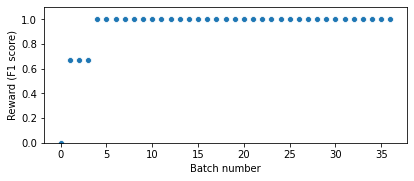

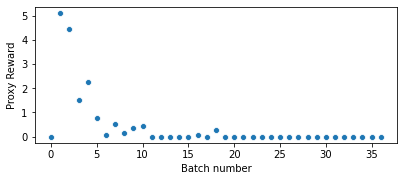

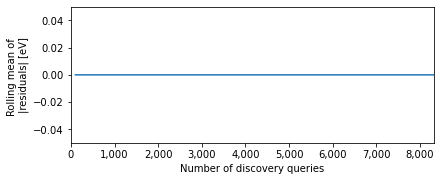

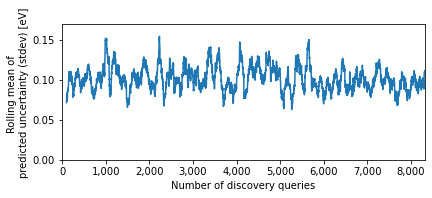

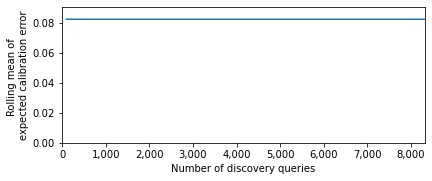

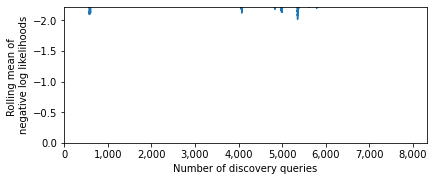

In [6]:
reward_fig, proxy_fig, accuracy_fig, uncertainty_fig, calibration_fig, nll_fig = discoverer.plot_performance(window=100)